In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [3]:
class Inception(nn.Module):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大汇聚层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

GoogLeNet 一共使用 9 个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于 AlexNet 和 LeNet，Inception块的栈从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用 64 个通道、  7×7  卷积层。

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64,kernel_size=7,stride=2,padding=3),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第二个模块使用两个卷积层：第一个卷积层是 64个通道、  1×1  卷积层；第二个卷积层使用将通道数量增加三倍的  3×3  卷积层。 这对应于 Inception 块中的第二条路径。

In [5]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                  nn.ReLU(),
                  nn.Conv2d(64,192,kernel_size=3,padding = 1),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [6]:
b3 = nn.Sequential(Inception(192,64,(96,128),(16,32),32),
                  Inception(256,128,(128,192),(32,96),64),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第四模块更加复杂， 它串联了5个Inception块，其输出通道数分别是  
192+208+48+64=512  、  
160+224+64+64=512  、  
128+256+64+64=512  、  
112+288+64+64=528  
256+320+128+128=832  。 z
这些路径的通道数分配和第三模块中的类似，
首先是含  3×3  卷积层的第二条路径输出最多通道，
其次是仅含  1×1  卷积层的第一条路径，
之后是含  5×5  卷积层的第三条路径和含  3×3  最大汇聚层的第四条路径。 
其中第二、第三条路径都会先按比例减小通道数。 这些比例在各个 Inception 块中都略有不同。

In [7]:
b4 = nn.Sequential(Inception(480,192,(96,208),(16,48),64),
                Inception(512,160,(112,224),(24,64),64),
                Inception(512,128,(128,256),(24,64),64),
                Inception(512,112,(144,288),(32,64),64),
                Inception(528,256,(160,320),(32,128),128),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第五模块包含输出通道数为  256+320+128+128=832  和  384+384+128+128=1024  的两个Inception块。 其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。 需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均汇聚层，将每个通道的高和宽变成1。 最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。

In [8]:
b5 = nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                      Inception(832,384,(192,384),(48,128),128),
                      nn.AdaptiveAvgPool2d((1,1)),
                      nn.Flatten())

In [9]:
net = nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

### 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96

In [10]:
X = torch.randn(size=(1,1,96,96))
for layer in net:
    X =layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


/home/wyr/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.242, train acc 0.908, test acc 0.883
1663.4 examples/sec on cuda:0


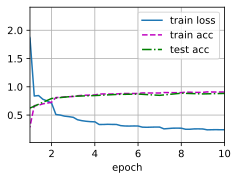

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
!nvidia-smi

Tue Aug 10 11:10:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   40C    P5    19W / 160W |   2801MiB /  5931MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------